In [1]:
##################################
# 1. Carga de datos
##################################
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix
from scipy.stats import zscore
from scipy.sparse import csr_matrix

# Cargar los datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv",sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv",sep=";")

train_data

,Label,Texto
0,0,rita maestre anuncia que en agosto llegarán 34...
1,0,psoe aclara que la mesa de negociación debe se...
2,0,campaña por la educación nueva propuesta legis...
3,1,educación y formación profesional destina más ...
4,1,la resurrección del presupuesto de andalucía y...
...,...,...
51988,0,nueva fórmula de alfonso guerra contra los par...
51989,0,el ministerio de sanidad lanza una campaña par...
51990,0,feijóo ensaya para las generales y moreno se s...
51991,0,el ministerio de educación anuncia nuevas medi...


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from scipy.sparse.linalg import norm
from scipy.stats import zscore
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#####################################
# Configuración de entorno y datos
#####################################

# Dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cargar datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

# Remover filas con datos faltantes
train_data = train_data.dropna(subset=['Texto', 'Label'])
val_data = val_data.dropna(subset=['Texto', 'Label'])
test_data = test_data.dropna(subset=['Texto', 'Label'])

# Separar características y etiquetas
X_train = train_data['Texto']
y_train = train_data['Label']

X_val = val_data['Texto']
y_val = val_data['Label']

X_test = test_data['Texto']
y_test = test_data['Label']

#####################################
# Preprocesamiento de texto
#####################################

# 1. Vectorización TF-IDF
tfidf_vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = tfidf_vectorizer_ngrams.fit_transform(X_train)
X_val_vec = tfidf_vectorizer_ngrams.transform(X_val)
X_test_vec = tfidf_vectorizer_ngrams.transform(X_test)

# 2. Selección de características (chi-cuadrado)
selector = SelectKBest(chi2, k=3000)
X_train_reduced = selector.fit_transform(X_train_vec, y_train)
X_val_reduced = selector.transform(X_val_vec)
X_test_reduced = selector.transform(X_test_vec)

# 3. Normalización de datos
scaler = StandardScaler(with_mean=False)
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_val_normalized = scaler.transform(X_val_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# 4. Filtrado de outliers con z-score
row_norms = norm(X_train_normalized, axis=1)
z_scores = zscore(row_norms)
mask = np.abs(z_scores) < 2.5
X_train_cleaned = X_train_normalized[mask]
y_train_cleaned = y_train[mask]

#####################################
# Conversión a Tensores de PyTorch
#####################################

X_train_tensor = torch.tensor(X_train_cleaned.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_cleaned.values, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_normalized.toarray(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_normalized.toarray(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

#####################################
# Definición del modelo
#####################################

class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)  # No aplicar sigmoid aquí

# Crear el modelo
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionTorch(input_dim).to(device)

#####################################
# Función de pérdida con ponderaciones ajustadas
#####################################

# Ponderación ajustada de la clase positiva
pos_weight = torch.tensor(2).to(device)

# Función de pérdida con la nueva ponderación
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

#####################################
# Parámetros de entrenamiento
#####################################

learning_rate = 0.0001
momentum = 0.9
epochs = 100000

#####################################
# Definir función de actualización (SGD con momentum)
#####################################

def sgd_momentum_step(model, velocities, lr=0.0001, momentum=0.9):
    with torch.no_grad():
        for param, v in zip(model.parameters(), velocities):
            if param.grad is not None:
                v.mul_(momentum).add_(param.grad, alpha=-lr)
                param.add_(v)

velocities = [torch.zeros_like(param, device=device) for param in model.parameters()]
losses_train = []
losses_val = []
accuracies_val = []

for epoch in range(epochs):
    model.train()
    model.zero_grad()

    # Cálculo de la pérdida de entrenamiento
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    losses_train.append(loss.item())
    
    loss.backward()
    sgd_momentum_step(model, velocities, lr=learning_rate, momentum=momentum)

    # Evaluación en el conjunto de validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)
        losses_val.append(val_loss.item())

        # Precisión en validación
        val_predictions = (torch.sigmoid(val_outputs) > 0.7).float()
        val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
        accuracies_val.append(val_accuracy)

    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

#####################################
# Evaluación en Validación
#####################################

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor).squeeze()
    val_predictions = (torch.sigmoid(val_outputs) > 0.7).float()  # Ajuste del umbral

    # Calcular matriz de confusión
    val_conf_matrix = confusion_matrix(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    TN, FP, FN, TP = val_conf_matrix.ravel()

    # Calcular métricas
    val_precision = precision_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_f1 = f1_score(y_val_tensor.cpu().numpy(), val_predictions.cpu().numpy())
    val_sensitivity = TP / (TP + FN)
    val_specificity = TN / (TN + FP)

print("\nValidation Metrics:")
print(f"Precision: {val_precision:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"Sensitivity: {val_sensitivity:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print("Confusion Matrix:\n", val_conf_matrix)

#####################################
# Evaluación en Prueba
#####################################

with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_predictions = (torch.sigmoid(test_outputs) > 0.7).float()  # Ajuste del umbral

    # Calcular matriz de confusión
    test_conf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    TN, FP, FN, TP = test_conf_matrix.ravel()

    # Calcular métricas
    test_precision = precision_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_f1 = f1_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())
    test_sensitivity = TP / (TP + FN)
    test_specificity = TN / (TN + FP)

print("\nTest Metrics:")
print(f"Precision: {test_precision:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"F1-Score: {test_f1:.3f}")
print(f"Sensitivity: {test_sensitivity:.3f}")
print(f"Specificity: {test_specificity:.3f}")
print("Confusion Matrix:\n", test_conf_matrix)


Using device: cuda
Epoch [0/100000], Loss: 1.0933, Val Loss: 1.1110
Epoch [1000/100000], Loss: 0.6940, Val Loss: 0.7298
Epoch [2000/100000], Loss: 0.6358, Val Loss: 0.6848
Epoch [3000/100000], Loss: 0.6109, Val Loss: 0.6690
Epoch [4000/100000], Loss: 0.5969, Val Loss: 0.6623
Epoch [5000/100000], Loss: 0.5879, Val Loss: 0.6592
Epoch [6000/100000], Loss: 0.5815, Val Loss: 0.6579
Epoch [7000/100000], Loss: 0.5768, Val Loss: 0.6575
Epoch [8000/100000], Loss: 0.5731, Val Loss: 0.6577
Epoch [9000/100000], Loss: 0.5702, Val Loss: 0.6581
Epoch [10000/100000], Loss: 0.5678, Val Loss: 0.6588
Epoch [11000/100000], Loss: 0.5658, Val Loss: 0.6595
Epoch [12000/100000], Loss: 0.5641, Val Loss: 0.6602
Epoch [13000/100000], Loss: 0.5626, Val Loss: 0.6609
Epoch [14000/100000], Loss: 0.5613, Val Loss: 0.6617
Epoch [15000/100000], Loss: 0.5601, Val Loss: 0.6624
Epoch [16000/100000], Loss: 0.5591, Val Loss: 0.6631
Epoch [17000/100000], Loss: 0.5582, Val Loss: 0.6638
Epoch [18000/100000], Loss: 0.5574, Val 

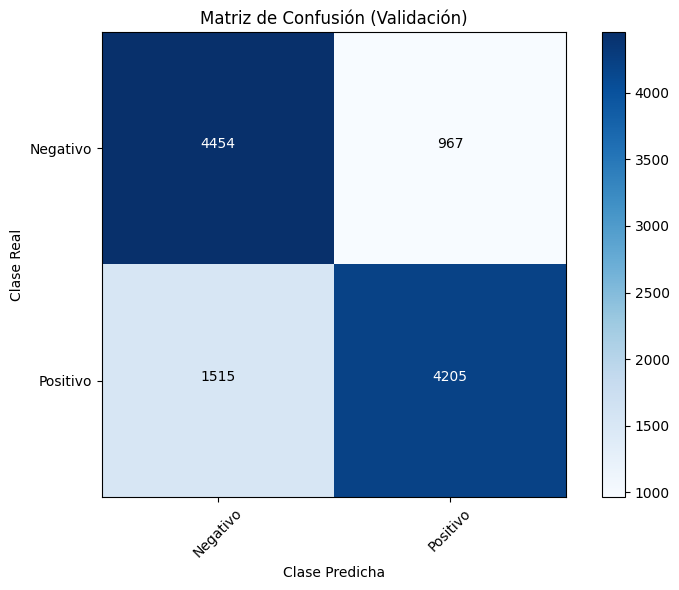

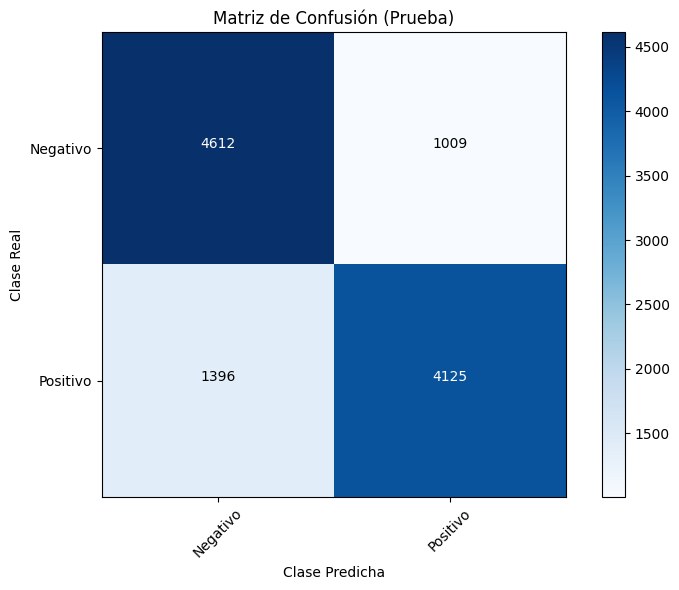

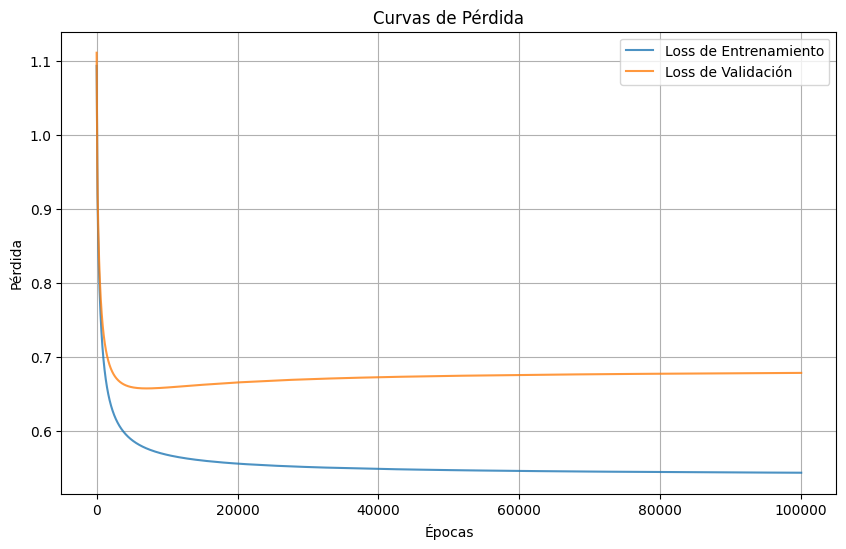

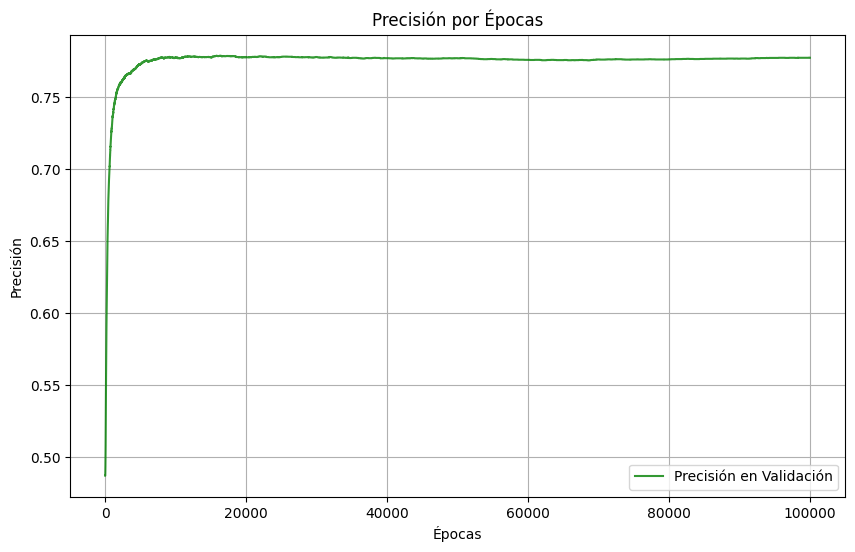

In [3]:
#####################################
# Visualización de la Matriz de Confusión
#####################################

def plot_confusion_matrix(cm, classes, title="Matriz de Confusión", cmap=plt.cm.Blues):
    """
    Esta función dibuja la matriz de confusión como gráfico.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.tight_layout()

# Llamar a la función para graficar la matriz de confusión en Validación
plot_confusion_matrix(
    val_conf_matrix,
    classes=["Negativo", "Positivo"],
    title="Matriz de Confusión (Validación)"
)

# Llamar a la función para graficar la matriz de confusión en Prueba
plot_confusion_matrix(
    test_conf_matrix,
    classes=["Negativo", "Positivo"],
    title="Matriz de Confusión (Prueba)"
)

#####################################
# Gráfica de curvas de pérdida
#####################################

plt.figure(figsize=(10, 6))
plt.plot(losses_train, label="Loss de Entrenamiento", alpha=0.8)
plt.plot(losses_val, label="Loss de Validación", alpha=0.8)
plt.title("Curvas de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

#####################################
# Gráfica de precisión por épocas
#####################################

plt.figure(figsize=(10, 6))
plt.plot(accuracies_val, label="Precisión en Validación", color="green", alpha=0.8)
plt.title("Precisión por Épocas")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()
